<a href="https://colab.research.google.com/github/pgurazada/prompt-engineering/blob/main/advanced_prompting_Llama2_mistral7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=8>Rephrase and Repond & CoVe Prompting</center></font></h1>
<h1><center>Llama 2 and Mistral 7b</center></h1>
<h3><center>Charlcye Mitchell, April 2024</center></h3>

<center>
<h1><b>Advanced Prompt Engineering with Llama2 and Mistral 7b</b>
</center>

# Objectives

Present the following techniques for prompt engineering using Llama2 13b and Mistral 7b:
- Self-consistency
- Tree-of-Thought
- Rephrase & Respond
- Chain-of-Verification


# Setup

Note: This notebook needs to be executed with a GPU runtime since we load and use LLaMA2 & Mistral 7b for inference. Both these models benefit from parallel execution offered by a GPU runtime (code in this notebook runs up to 4 times faster). See screenshots below to create a GPU runtime on a Colab instance.

*Step 1:*

Select the `Runtime` option from the main menu and select the `Change runtime type` from the dropdown.

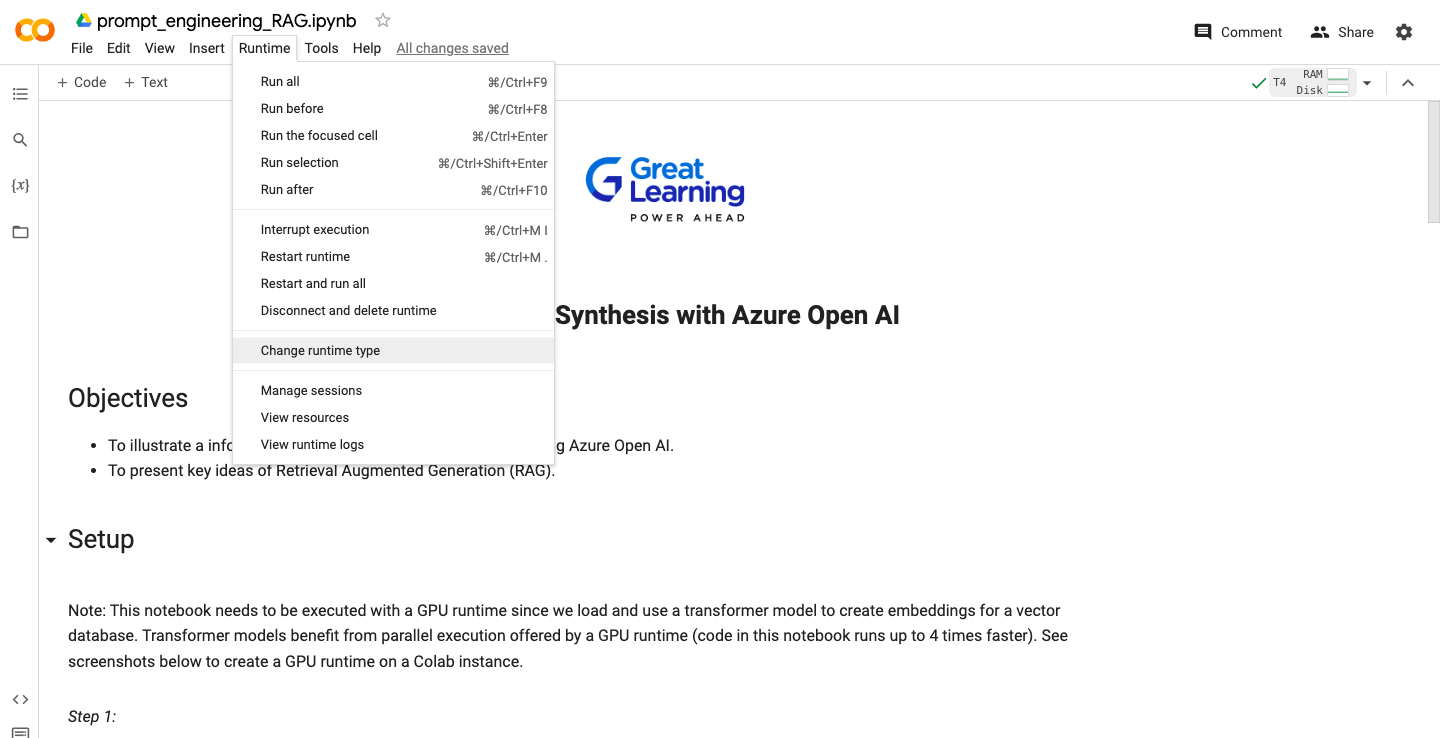

Select `T4 GPU` from the options presented under Hardware accelerator.

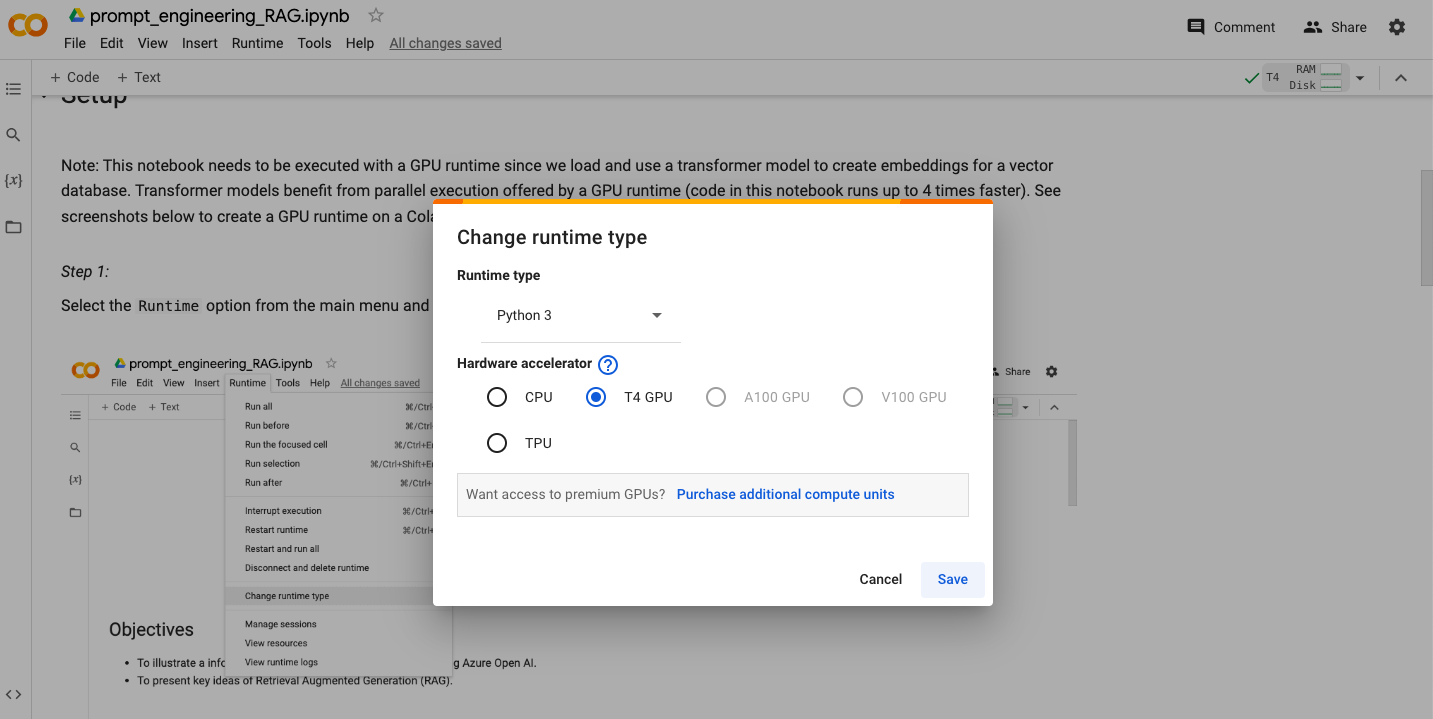

You should now see the T4 GPU mentioned in the runtime logo (screenshot below).

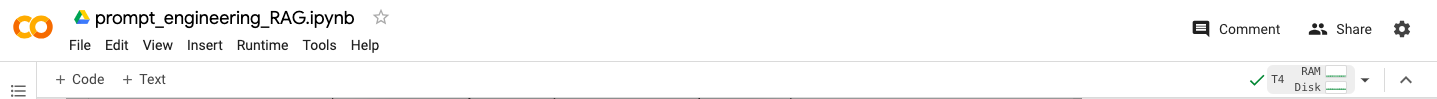

## Installation

In [ ]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.32-cp310-cp310-manylinux_2_35_x86_64.whl size=9379345 sha256=975f8e6084589210e24a2bf01b584b5740add961aeb6beaa09e4e62bbf0d1520
  Stored in directory: /root/.cache/pip/wheels/fd/34/e2/592ae50a491d192807efe8a6abcb3622fb2190402252a7258f
Successfully built llama-cpp-python


In [ ]:
!pip install -q huggingface_hub

## Imports

In [ ]:
import json

from huggingface_hub import hf_hub_download
from llama_cpp import Llama

# Llama2

### Model

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf"

In [ ]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096 # Context window
)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
Model metadata: {'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.eos_token_id': '2', 'general.architecture': 'llama', 'llama.context_length': '4096', 'general.name': 'LLaMA v2', 'llama.embedding_length': '5120', 'llama.feed_forward_length': '13824', 'llama.attention.layer_norm_rms_epsilon': '0.000010', 'llama.rope.dimension_count': '128', 'llama.attention.head_count': '40', 'tokenizer.ggml.bos_token_id': '1', 'llama.block_count': '40', 'llama.attention.head_count_kv': '40', 'general.quantization_version': '2', 'tokenizer.ggml.model': 'llama', 'general.file_type': '17'}


In [ ]:
llama2_prompt_template = """<s>[INST]<<SYS>>
{system_message}
<</SYS>>

{user_message}[/INST]"""

## Self-consistency

In self-consistency, we generate multiple answers to the same question and pick the answer that is repeated the most across these occurrences. This is particularly valuable for factual questions.

In [ ]:
system_message = """
You are an assistant tasked to answer queries on financial information.
Do not repeat the question. Only answer the question presented by the user.
"""

In [ ]:
answers_template = """
Context:
{context}
===
Using the context above generate {num_answers} distinct answers to the following question:
Question:
{question}.

Arrange your answers in numbered bullet points.
Present only the answers in bullet points.
"""

Here is an extract from the Tesla 2022 10-K statement that will be used as context for this demonstration.

In [ ]:
tesla_annual_report_context ="""
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
"""

In [ ]:
factual_question = "What was the increase in annual revenue in 2022 compared to 2021?"

In [ ]:
answers_prompt = llama2_prompt_template.format(
    system_message=system_message,
    user_message=answers_template.format(
        context=tesla_annual_report_context,
        question=factual_question,
        num_answers=3
    )
)

In [ ]:
print(answers_prompt)

<s>[INST]<<SYS>>

You are an assistant tasked to answer queries on financial information.
Do not repeat the question. Only answer the question presented by the user.

<</SYS>>


Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===
Using the context above generate 3 distinct answers to the following question:
Question:
What was the increase in annual revenue in 2022 compared to 2021?.

Arrange your answers in numbered bullet points.
Present only the answers in bullet points.
[/INST]


In [ ]:
response = lcpp_llm(
    prompt=answers_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"])

  Sure, here are three distinct answers to the question "What was the increase in annual revenue in 2022 compared to 2021?" based on the provided context:

1. The increase in annual revenue in 2022 compared to 2021 was $27.64 billion.
2. Our annual revenues grew by 38% from 2021 to 2022, totaling $81.46 billion.
3. We experienced a significant increase in revenue of $27.64 billion between 2021 and 2022, bringing our total annual revenues to $81.46 billion.


In [ ]:
factual_answers = response["choices"][0]["text"]

In [ ]:
consistency_template = """
Here are {num_answers} answers to the question mentioned below:
Question:
{question}
Answers:
{answers}

Observe the answers mentioned above and choose the answer that occurs most.
Present only the most frequent solution in the following format.
Final Answer:
"""

In [ ]:
consistency_prompt = llama2_prompt_template.format(
    system_message=system_message,
    user_message=consistency_template.format(
        num_answers=3,
        question=factual_question,
        answers=factual_answers
    )
)

In [ ]:
response = lcpp_llm(
    prompt=consistency_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"])

  Sure! Based on the provided context, the most frequent answer is:

Final Answer: The increase in annual revenue in 2022 compared to 2021 was $27.64 billion.


## Tree-of-Thought

Tree-of-thought prompting is a generalization of chain-of-thought prompting where the model is prompted to take multiple reasoning paths. This forces the LLM into a deliberate reasoning mode.

In [ ]:
solutions_template = """
Generate {num_solutions} distinct solutions for the following problem:
Problem:
{problem}.
--

Consider the following factors in coming up with your solutions.
Factors:
{factors}

Present the solutions in numbered bullet points. Present only the solutions.
"""

In [ ]:
climate_problem = "Reduce the impact of climate change on the occurrence of extreme events in the Earth's atmosphere."

climate_factors = """
1. Renewable Energy Transition
2. Reforestation
3. Sustainable Agricultural Practises
4. Carbon capture and storage
5. Climate-resilient infrastructure
6. Circular economy practises
"""

In [ ]:
solutions_prompt = llama2_prompt_template.format(
    system_message='',
    user_message=solutions_template.format(
        num_solutions=3,
        problem=climate_problem,
        factors=climate_factors
    )
)

In [ ]:
response = lcpp_llm(
    prompt=solutions_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"])

  Sure, here are three distinct solutions for reducing the impact of climate change on extreme events:

Solution 1: Renewable Energy Transition

• Accelerate the transition to renewable energy sources such as wind and solar power to reduce dependence on fossil fuels and lower carbon emissions.
• Invest in research and development of new technologies to improve efficiency and affordability of renewables.
• Implement policies to promote the adoption of renewables, such as tax credits or feed-in tariffs.

Solution 2: Reforestation and Sustainable Land Use

• Restore degraded lands and forests to their natural state through reforestation efforts.
• Implement sustainable agricultural practices that promote soil health, biodiversity, and carbon sequestration.
• Promote agroforestry techniques that integrate trees into farming systems.

Solution 3: Climate-Resilient Infrastructure and Circular Economy Practices

• Build climate-resilient infrastructure such as sea walls, levees, and green roo

In [ ]:
climate_solutions = response["choices"][0]["text"]

In [ ]:
evaluation_template = """
For the following problem: {problem}, evaluate each solution in the following proposed solutions: \n{solutions}\n.

Analyze pros, cons, feasibility, and probability of success for each solution.
Present your evaluations of each solutions.
"""

In [ ]:
evaluations_prompt = llama2_prompt_template.format(
    system_message='',
    user_message=evaluation_template.format(
        problem=climate_problem,
        solutions=climate_solutions
    )
)

In [ ]:
response = lcpp_llm(
    prompt=evaluations_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
climate_proposal_evaluations = response["choices"][0]["text"]

In [ ]:
print(climate_proposal_evaluations)

  Sure! Here are my evaluations of the three proposed solutions to reduce the impact of climate change on extreme events:

Solution 1: Renewable Energy Transition

Pros:

* Reduces dependence on fossil fuels and lowers carbon emissions, which contribute to climate change.
* Can create jobs and stimulate economic growth in the renewable energy sector.
* Improves air quality and public health by reducing pollution from fossil fuel combustion.

Cons:

* Requires significant investment in infrastructure and technology development.
* May face resistance from fossil fuel industries and communities reliant on them.
* Intermittent nature of renewable energy sources can create power grid stability challenges.

Feasibility: High probability of success, as many countries have already made significant progress in transitioning to renewable energy sources. However, the pace of transition needs to be accelerated to meet climate change mitigation goals.

Probability of Success: 8/10

Solution 2: Refo

In [ ]:
ranking_template = """
For the following problem: {problem}, rank the solutions presented in the following evaluations: \n{evaluations}\n.
Pick most promising solution and present implementation strategies and methods to handle potential obstacles for this solution.
"""

In [ ]:
ranking_prompt = llama2_prompt_template.format(
    system_message='',
    user_message=ranking_template.format(
        problem=climate_problem,
        evaluations=climate_proposal_evaluations
    )
)

In [ ]:
response = lcpp_llm(
    prompt=ranking_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
climate_proposal_rankings = response["choices"][0]["text"]

In [ ]:
print(climate_proposal_rankings)

  Based on the evaluations provided, the most promising solution for reducing the impact of climate change on extreme events is the transition to renewable energy sources. This solution has a high probability of success, as many countries have already made significant progress in transitioning to renewable energy sources, and it addresses multiple aspects of the climate crisis, including greenhouse gas emissions and air pollution.

To implement this solution effectively, the following implementation strategies can be considered:

1. Increase investment in renewable energy infrastructure: Governments and private investors should increase their investment in renewable energy technologies such as wind, solar, hydroelectric, and geothermal power. This will help to reduce our reliance on fossil fuels and lower carbon emissions.
2. Implement policies to support the transition: Governments can implement policies such as tax credits, feed-in tariffs, and renewable portfolio standards to incent

## Rephrase & Respond

In [ ]:
system_message = """
You are tasked to answer queries on financial information.
Only answer the specific question presented by the user.
"""

In [ ]:
rephrase_prompt_template = """
Context:
{context}
===

Question:
{question}.

Observe the context presented above, rephrase and expand the above question to help you do better answering.
Maintain all the information in the original question.
Please note that you only have to rephrase the question, do not mention the context.
The context is only presented for your reference.

Present your answer in the following format:
Rephrased Question:
<rephrased-question-here>
"""

Here is an extract from the Tesla 2022 10-K statement that will be used as context for this demonstration.

In [ ]:
tesla_annual_report_context ="""
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
"""

In [ ]:
factual_question = "What was the increase in annual revenue in 2022 compared to 2021?"

In [ ]:
rephrase_prompt = llama2_prompt_template.format(
    system_message=system_message,
    user_message=rephrase_prompt_template.format(
        context=tesla_annual_report_context,
        question=factual_question
    )
)

In [ ]:
print(rephrase_prompt)

<s>[INST]<<SYS>>

You are tasked to answer queries on financial information.
Only answer the specific question presented by the user. 

<</SYS>>


Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Question:
What was the increase in annual revenue in 2022 compared to 2021?.

Observe the context presented above, rephrase and expand the above question to help you do better answering.
Maintain all the information in the original question.
Please note that you only have to rephrase the question, do not mention the context. 
The context is only presented for your reference.

Present your answer in the following format:
Rephrased Question:
<rephrased-question-here>
[/INST]


In [ ]:
response = lcpp_llm(
    prompt=rephrase_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
rephrased_question = response["choices"][0]["text"].strip()

In [ ]:
print(rephrased_question)

Sure! Here's the rephrased question based on the provided context:

Rephrased Question: What was the increase in annual revenues from 2021 to 2022? Specifically, what was the dollar amount of the increase in total revenues during this period?


In [ ]:
rephrase_marker = rephrased_question.find('Rephrased Question:')

In [ ]:
print(rephrased_question[rephrase_marker+19:])

 What was the increase in annual revenues from 2021 to 2022? Specifically, what was the dollar amount of the increase in total revenues during this period?


In [ ]:
rephrased_factual_question = rephrased_question[rephrase_marker+19:]

In [ ]:
response_template = """
Context:
{context}
===

Original Question:
{question}

Rephrased Question:
{rephrased_question}

Given the above context, use your answer for the rephrased question presented above to answer the original question.
Present your final answer in the following format.
Final Answer: <your-final-answer>
"""

In [ ]:
response_prompt = llama2_prompt_template.format(
    system_message=system_message,
    user_message=response_template.format(
        context=tesla_annual_report_context,
        question=factual_question,
        rephrased_question=rephrased_factual_question
    )
)

In [ ]:
print(response_prompt)

<s>[INST]<<SYS>>

You are tasked to answer queries on financial information.
Only answer the specific question presented by the user. 

<</SYS>>


Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Original Question:
What was the increase in annual revenue in 2022 compared to 2021?

Rephrased Question:
 What was the increase in annual revenues from 2021 to 2022? Specifically, what was the dollar amount of the increase in total revenues during this period?

Given the above context, use your answer for the rephrased question presented above to answer the original question.
Present your final answer in the following format.
Final Answer: <your-final-answer>
[/INST]


In [ ]:
response = lcpp_llm(
    prompt=response_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"].strip())

Sure! Based on the information provided, the increase in annual revenues from 2021 to 2022 was $27.64 billion. This is calculated by taking the total revenues for 2022 ($81.46 billion) and subtracting the total revenues for 2021.

Final Answer: $27.64 billion


# Chain-of-Verification (CoVe)

In [ ]:
system_message = """
You are tasked to answer queries on financial information.
Only answer the specific question presented by the user.
"""

## Step 1: Baseline response

In [ ]:
baseline_prompt_template = """
Context:
{context}
===

Use the above context to answer the following question:
Question:
{question}
"""

Here is an extract from the Tesla 2022 10-K statement that will be used as context for this demonstration.

In [ ]:
tesla_annual_report_context ="""
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
"""

In [ ]:
factual_question = "Which year had more revenue - 2022 or 2021?"

In [ ]:
baseline_prompt = llama2_prompt_template.format(
    system_message=system_message,
    user_message=baseline_prompt_template.format(
        context=tesla_annual_report_context,
        question=factual_question
    )
)

In [ ]:
print(baseline_prompt)

<s>[INST]<<SYS>>

You are tasked to answer queries on financial information.
Only answer the specific question presented by the user. 

<</SYS>>


Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Use the above context to answer the following question:
Question:
Which year had more revenue - 2022 or 2021?
[/INST]


In [ ]:
response = lcpp_llm(
    prompt=baseline_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
baseline_factual_response = response["choices"][0]["text"].strip()

In [ ]:
print(baseline_factual_response)

Sure! Based on the information provided in the context, we can see that in 2022, total revenues were $81.46 billion, compared to $53.82 billion in 2021. Therefore, 2022 had more revenue than 2021.


## Step 2: Verification questions

In [ ]:
verifications_prompt_template = """
Your task is to create verification questions based on the below original question and the baseline response.
The verification questions are meant for verifying the factual acuracy in the baseline response.

Context:
{context}
===

Question:
Use the above context to answer the following question: {question}

Baseline Response:
{baseline_response}

Respond with your verification questions in a JSON format with the following headers.
```JSON
question1: <verification-question-1>
question2: <veriification-question-2>
and so on.
```
Do not provide answers to these verification questions. Respond only with the JSON.
"""

In [ ]:
verifications_prompt = llama2_prompt_template.format(
    system_message=system_message,
    user_message=verifications_prompt_template.format(
        context=tesla_annual_report_context,
        question=factual_question,
        baseline_response=baseline_factual_response
    )
)

In [ ]:
print(verifications_prompt)

<s>[INST]<<SYS>>

You are tasked to answer queries on financial information.
Only answer the specific question presented by the user. 

<</SYS>>


Your task is to create verification questions based on the below original question and the baseline response.
The verification questions are meant for verifying the factual acuracy in the baseline response.

Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Question:
Use the above context to answer the following question: Which year had more revenue - 2022 or 2021?

Baseline Response:
Sure! Based on the information provided in the context, we can see that in 2022, total revenues were $81.46 billion, compared to $53.82 billion in 2021. Therefore, 2022 had m

In [ ]:
response = lcpp_llm(
    prompt=verifications_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
verification_factual_questions = response["choices"][0]["text"].strip()

In [ ]:
print(verification_factual_questions)

Sure, here are three verification questions based on the provided context and baseline response:

{
"question1": "What was the total revenue in 2021 according to the context?",
"question2": "How much did total revenues increase from 2021 to 2022, as stated in the baseline response?",
"question3": "In which year did the company recognize more revenue, based on the information provided in the baseline response?"
}


## Step 3: Verification responses

In [ ]:
verification_responses_template = """Answer the following question correctly based on the context given below:
Context:
{context}
===

Question: {verification_question}"""

In [ ]:
verification_question_beginning = verification_factual_questions.find("{")

In [ ]:
verification_factual_questions_dict = json.loads(verification_factual_questions[verification_question_beginning:])

In [ ]:
verification_responses = []

In [ ]:
verification_factual_questions_dict.values()

dict_values(['What was the total revenue in 2021 according to the context?', 'How much did total revenues increase from 2021 to 2022, as stated in the baseline response?', 'In which year did the company recognize more revenue, based on the information provided in the baseline response?'])

In [ ]:
for verification_factual_question in verification_factual_questions_dict.values():

    verification_responses_prompt = llama2_prompt_template.format(
        system_message=system_message,
        user_message=verification_responses_template.format(
            context=tesla_annual_report_context,
            verification_question=verification_factual_question
        )
    )

    response = lcpp_llm(
        prompt=verification_responses_prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False # do not return the prompt
    )

    verification_responses.append(response["choices"][0]["text"].strip())

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for q, a in zip(verification_factual_questions_dict.values(), verification_responses):
    print(q)
    print(a)

What was the total revenue in 2021 according to the context?
Based on the context provided, the total revenue in 2021 is $81.46 billion.
How much did total revenues increase from 2021 to 2022, as stated in the baseline response?
Sure! Based on the context you provided, the answer to your question is:

Total revenues increased by $27.64 billion from 2021 to 2022.
In which year did the company recognize more revenue, based on the information provided in the baseline response?
Based on the information provided in the context, the company recognized more revenue in 2022 than in the prior year. The total revenues for 2022 were $81.46 billion, which is an increase of $27.64 billion compared to the prior year.


In [ ]:
verification_factual_question_answer_pairs = ''

for q, a in zip(verification_factual_questions_dict.values(), verification_responses):
    verification_factual_question_answer_pairs += ('\n' + \
    f"Verification Question: {q}" + '\n' + \
    f"Response: {a}"
)

In [ ]:
print(verification_factual_question_answer_pairs)


Verification Question: What was the total revenue in 2021 according to the context?
Response: Based on the context provided, the total revenue in 2021 is $81.46 billion.
Verification Question: How much did total revenues increase from 2021 to 2022, as stated in the baseline response?
Response: Sure! Based on the context you provided, the answer to your question is:

Total revenues increased by $27.64 billion from 2021 to 2022.
Verification Question: In which year did the company recognize more revenue, based on the information provided in the baseline response?
Response: Based on the information provided in the context, the company recognized more revenue in 2022 than in the prior year. The total revenues for 2022 were $81.46 billion, which is an increase of $27.64 billion compared to the prior year.


## Step 4: Final prompt

In [ ]:
final_prompt_template = """
Given the below `Context`, `Original Query` and `Baseline Answer`, analyze the `Verification Questions & Answers` to finally filter the refined answer.
Context:
{context}
===
Original Query: {original_question}
Baseline Answer: {baseline_response}

Verification Questions & Answer Pairs:
{verification_question_answer_pairs}

To reiterate, you should answer the original query accounting for the veracity of the verification question answer pairs and the context.
Only answer the original question and do not present any additional details. Present your final answer in the following format:
Final Refined Answer:<your-final-answer>"""

In [ ]:
final_prompt = llama2_prompt_template.format(
    system_message=system_message,
    user_message=final_prompt_template.format(
        context=tesla_annual_report_context,
        original_question=factual_question,
        baseline_response=baseline_factual_response,
        verification_question_answer_pairs=verification_factual_question_answer_pairs
    )
)

In [ ]:
print(final_prompt)

<s>[INST]<<SYS>>

You are tasked to answer queries on financial information.
Only answer the specific question presented by the user. 

<</SYS>>


Given the below `Context`, `Original Query` and `Baseline Answer`, analyze the `Verification Questions & Answers` to finally filter the refined answer.
Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===
Original Query: Which year had more revenue - 2022 or 2021?
Baseline Answer: Sure! Based on the information provided in the context, we can see that in 2022, total revenues were $81.46 billion, compared to $53.82 billion in 2021. Therefore, 2022 had more revenue than 2021.

Verification Questions & Answer Pairs:

Verification Question: What was the total reve

In [ ]:
response = lcpp_llm(
    prompt=final_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"].strip())

Final Refined Answer: Based on the information provided, 2022 had more revenue than 2021.


# Mistral 7b

### Model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q5_K_M.gguf" # the model is in gguf format

In [ ]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q5_K_M.gguf:   0%|          | 0.00/5.13G [00:00<?, ?B/s]

In [ ]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43, # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096 # Context window
)

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 1 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
Model metadata: {'tokenizer.chat_template': "{{ bos_token }}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if message['role'] == 'user' %}{{ '[INST] ' + message['content'] + ' [/INST]' }}{% elif message['role'] == 'assistant' %}{{ message['content'] + eos_token}}{% else %}{{ raise_exception('Only user and assistant roles are supported!') }}{% endif %}{% endfor %}", 'tokenizer.ggml.add_eos_token': 'false', 'tokenizer.ggml.padding_token_id': '0', 'tokenizer.ggml.unknown_token_id': '0', 'tokenizer.ggml.eos_token_id': '2', 'general.architecture': 'llama', 'llama.rope.freq_base': '1000000.000000', 'llama.context_length': '32768', 'general.na

In [ ]:
mistral_prompt_template = """<s>[INST]{prompt}[/INST]"""

## Self-consistency

In [self-consistency](https://arxiv.org/abs/2203.11171), we generate multiple answers to the same question and pick the answer that is repeated the most across these occurrences. This is particularly valuable for factual questions.

In [ ]:
answers_template = """
Context:
{context}
===
Using the context above generate {num_answers} distinct answers to the following question:
Question:
{question}.

Arrange your answers in numbered bullet points.
Present only the answers in bullet points.
"""

Here is an extract from the Tesla 2022 10-K statement that will be used as context for this demonstration.

In [ ]:
tesla_annual_report_context ="""
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
"""

In [ ]:
factual_question = "What was the increase in annual revenue in 2022 compared to 2021?"

In [ ]:
answers_prompt = mistral_prompt_template.format(
    prompt=answers_template.format(
        context=tesla_annual_report_context,
        question=factual_question,
        num_answers=3
    )
)

In [ ]:
response = lcpp_llm(
    prompt=answers_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

In [ ]:
factual_answers = response["choices"][0]["text"].strip()

In [ ]:
print(factual_answers)

* The increase in annual revenue from 2021 to 2022 was $27.64 billion.
* In 2022, total revenues were $81.46 billion, which is an increase of $27.64 billion compared to the previous year.
* The company experienced a revenue growth of approximately $27.64 billion between 2021 and 2022.


In [ ]:
consistency_template = """
Here are {num_answers} answers to the question mentioned below:
Question:
{question}
Answers:
{answers}

Observe the answers mentioned above and choose the answer that occurs most.
Present only the most frequent solution in the following format.
Final Answer:
"""

In [ ]:
consistency_prompt = mistral_prompt_template.format(
    prompt=consistency_template.format(
        num_answers=3,
        question=factual_question,
        answers=factual_answers
    )
)

In [ ]:
response = lcpp_llm(
    prompt=consistency_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"].strip())

Final Answer: The increase in annual revenue from 2021 to 2022 was $27.64 billion.


## Tree-of-Thought

[Tree-of-thought](https://arxiv.org/abs/2305.10601) prompting is a generalization of chain-of-thought prompting where the model is prompted to take multiple reasoning paths. This forces the LLM into a deliberate reasoning mode.

In [ ]:
solutions_template = """
Generate {num_solutions} distinct solutions for the following problem:
Problem:
{problem}.
--

Consider the following factors in coming up with your solutions.
Factors:
{factors}

Present the {num_solutions} solutions in numbered bullet points. Present only the solutions.
"""

In [ ]:
climate_problem = "Reduce the impact of climate change on the occurrence of extreme events in the Earth's atmosphere."

climate_factors = """
1. Renewable Energy Transition
2. Reforestation
3. Sustainable Agricultural Practises
4. Carbon capture and storage
5. Climate-resilient infrastructure
6. Circular economy practises
"""

In [ ]:
solutions_prompt = mistral_prompt_template.format(
    prompt=solutions_template.format(
        num_solutions=3,
        problem=climate_problem,
        factors=climate_factors
    )
)

In [ ]:
response = lcpp_llm(
    prompt=solutions_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
climate_solutions = response["choices"][0]["text"].strip()

In [ ]:
print(climate_solutions)

Solution 1:
- Accelerate the transition to renewable energy sources by investing in solar, wind, hydroelectric, and other clean energy technologies.
- Encourage governments and businesses to set ambitious targets for reducing greenhouse gas emissions.
- Implement policies that incentivize individuals and organizations to adopt renewable energy solutions.

Solution 2:
- Increase global reforestation efforts by planting new trees, protecting existing forests, and promoting sustainable forest management practices.
- Encourage the use of agroforestry systems, which combine agriculture with tree cultivation, to help sequester carbon and reduce deforestation.
- Support research into innovative approaches for afforestation (planting new forests in previously treeless areas) and reforestation (reestablishing forests on degraded or deforested land).

Solution 3:
- Implement climate-resilient infrastructure projects, such as green roofs, rainwater harvesting systems, and permeable pavements.
- E

In [ ]:
evaluation_template = """
For the following problem: {problem}, evaluate each solution in the following proposed solutions: \n{solutions}\n.

Analyze pros, cons, feasibility, and probability of success for each solution.
Present your evaluations of each solutions.
"""

In [ ]:
evaluations_prompt = mistral_prompt_template.format(
    prompt=evaluation_template.format(
        problem=climate_problem,
        solutions=climate_solutions
    )
)

In [ ]:
response = lcpp_llm(
    prompt=evaluations_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
climate_proposal_evaluations = response["choices"][0]["text"].strip()

In [ ]:
print(climate_proposal_evaluations)

Solution 1: Transitioning to Renewable Energy Sources
Pros:
- Reduces greenhouse gas emissions from the power sector, which is a major contributor to climate change.
- Creates jobs and stimulates economic growth in the renewable energy industry.
- Decreases dependence on fossil fuels, reducing vulnerability to price volatility and supply disruptions.
Cons:
- High upfront costs for infrastructure development and implementation of renewable energy technologies.
- Intermittency issues with some renewable sources (e.g., solar and wind) may require backup power or energy storage solutions.
- Political challenges in implementing policies that incentivize the transition to renewable energy, particularly in countries heavily reliant on fossil fuel industries.
Feasibility: Renewable energy technologies have become increasingly cost-competitive with traditional fossil fuels and are continuing to improve in efficiency. Many countries have already set ambitious targets for reducing greenhouse gas 

In [ ]:
ranking_template = """
For the following problem: {problem}, rank the solutions presented in the following evaluations: \n{evaluations}\n.
Pick most promising solution and present implementation strategies and methods to handle potential obstacles for this solution.
"""

In [ ]:
ranking_prompt = mistral_prompt_template.format(
    prompt=ranking_template.format(
        problem=climate_problem,
        evaluations=climate_proposal_evaluations
    )
)

In [ ]:
response = lcpp_llm(
    prompt=ranking_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
climate_proposal_rankings = response["choices"][0]["text"].strip()

In [ ]:
print(climate_proposal_rankings)

 Based on the evaluations provided, all three solutions - transitioning to renewable energy sources, reforestation and afforestation efforts, and climate-resilient infrastructure and circular economy practices - have their merits in reducing the impact of climate change on extreme events in the Earth's atmosphere. However, considering the current global context and the feasibility and probability of success for each solution, transitioning to renewable energy sources appears to be the most promising option.

Implementation Strategies:
1. Government Policies and Incentives: Governments can play a crucial role in implementing policies that incentivize the transition to renewable energy. This could include setting targets for reducing greenhouse gas emissions, providing subsidies or tax credits for renewable energy projects, and investing in research and development of new technologies.
2. Public-Private Partnerships: Collaboration between governments, private companies, and international

## Rephrase & Respond

In [ ]:
rephrase_prompt_template = """Context:
{context}
===

Question:
{question}.

Observe the context presented above, rephrase and expand the above question to help you do better answering.
Maintain all the information in the original question.
Please note that you only have to rephrase the question, do not mention the context.
The context is only presented for your reference.
"""

Here is an extract from the Tesla 2022 10-K statement that will be used as context for this demonstration.

In [ ]:
tesla_annual_report_context ="""
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
"""

In [ ]:
factual_question = "What was the increase in annual revenue in 2022 compared to 2021?"

In [ ]:
rephrase_prompt = mistral_prompt_template.format(
    prompt=rephrase_prompt_template.format(
        context=tesla_annual_report_context,
        question=factual_question
    )
)

In [ ]:
print(rephrase_prompt)

<s>[INST]Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Question:
What was the increase in annual revenue in 2022 compared to 2021?.

Observe the context presented above, rephrase and expand the above question to help you do better answering.
Maintain all the information in the original question.
Please note that you only have to rephrase the question, do not mention the context.
The context is only presented for your reference.
[/INST]


In [ ]:
response = lcpp_llm(
    prompt=rephrase_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

In [ ]:
rephrased_factual_question = response["choices"][0]["text"].strip()

In [ ]:
print(rephrased_factual_question)

What is the difference between the total revenues we generated in 2022 and those in 2021?


In [ ]:
response_template = """
Context:
{context}
===

Original Question:
{question}

Rephrased Question:
{rephrased_question}

Given the above context, use your answer for the rephrased question presented above to answer the original question.
Present your final answer in the following format.
Final Answer: <your-final-answer>
"""

In [ ]:
response_prompt = mistral_prompt_template.format(
    prompt=response_template.format(
        context=tesla_annual_report_context,
        question=factual_question,
        rephrased_question=rephrased_factual_question
    )
)

In [ ]:
print(response_prompt)

<s>[INST]
Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Original Question:
What was the increase in annual revenue in 2022 compared to 2021?

Rephrased Question:
What is the difference between the total revenues we generated in 2022 and those in 2021?

Given the above context, use your answer for the rephrased question presented above to answer the original question.
Present your final answer in the following format.
Final Answer: <your-final-answer>
[/INST]


In [ ]:
response = lcpp_llm(
    prompt=response_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"].strip())

Final Answer: The increase in annual revenue from 2021 to 2022 was $27.64 billion.


# Chain-of-Verification (CoVe)

## Step 1: Baseline response

In [ ]:
baseline_prompt_template = """
Context:
{context}
===

Use the above context to answer the following question:
Question:
{question}
"""

Here is an extract from the Tesla 2022 10-K statement that will be used as context for this demonstration.

In [ ]:
tesla_annual_report_context ="""
In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.
"""

In [ ]:
factual_question = "Which year had more revenue - 2022 or 2021?"

In [ ]:
baseline_prompt = mistral_prompt_template.format(
    prompt=baseline_prompt_template.format(
        context=tesla_annual_report_context,
        question=factual_question
    )
)

In [ ]:
print(baseline_prompt)

<s>[INST]
Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Use the above context to answer the following question:
Question:
Which year had more revenue - 2022 or 2021?
[/INST]


In [ ]:
response = lcpp_llm(
    prompt=baseline_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
baseline_factual_response = response["choices"][0]["text"].strip()

In [ ]:
print(baseline_factual_response)

The year 2022 had more revenue than 2021, with a total of $81.46 billion compared to $53.82 billion in the prior year.


## Step 2: Verification questions

In [ ]:
verifications_prompt_template = """
Your task is to create verification questions based on the below original question and the baseline response.
The verification questions are meant for verifying the factual acuracy in the baseline response.

Context:
{context}
===

Question:
Use the above context to answer the following question: {question}

Baseline Response:
{baseline_response}

Respond with your verification questions in a JSON format with the following headers.
question1: <verification-question-1>
question2: <veriification-question-2>
and so on.

Do not provide answers to these verification questions. Respond only with the JSON.
"""

In [ ]:
verifications_prompt = mistral_prompt_template.format(
    prompt=verifications_prompt_template.format(
        context=tesla_annual_report_context,
        question=factual_question,
        baseline_response=baseline_factual_response
    )
)

In [ ]:
print(verifications_prompt)

<s>[INST]
Your task is to create verification questions based on the below original question and the baseline response.
The verification questions are meant for verifying the factual acuracy in the baseline response.

Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===

Question:
Use the above context to answer the following question: Which year had more revenue - 2022 or 2021?

Baseline Response:
The year 2022 had more revenue than 2021, with a total of $81.46 billion compared to $53.82 billion in the prior year.

Respond with your verification questions in a JSON format with the following headers.
question1: <verification-question-1>
question2: <veriification-question-2>
and so on.

Do not provide ans

In [ ]:
response = lcpp_llm(
    prompt=verifications_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
verification_factual_questions = response["choices"][0]["text"].strip()

In [ ]:
print(verification_factual_questions)

{
"question1": "What was the total revenue in 2021 according to the context?",
"question2": "According to the context, what is the difference between the revenues of 2022 and 2021?"
}


## Step 3: Verification responses

In [ ]:
verification_responses_template = """Answer the following question correctly based on the context given below:
Context:
{context}
===

Question: {verification_question}"""

In [ ]:
verification_factual_questions_dict = json.loads(verification_factual_questions)

In [ ]:
verification_responses = []

In [ ]:
verification_factual_questions_dict.values()

dict_values(['What was the total revenue in 2021 according to the context?', 'According to the context, what is the difference between the revenues of 2022 and 2021?'])

In [ ]:
for verification_factual_question in verification_factual_questions_dict.values():

    verification_responses_prompt = mistral_prompt_template.format(
        prompt=verification_responses_template.format(
            context=tesla_annual_report_context,
            verification_question=verification_factual_question
        )
    )

    response = lcpp_llm(
        prompt=verification_responses_prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        echo=False # do not return the prompt
    )

    verification_responses.append(response["choices"][0]["text"].strip())

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
for q, a in zip(verification_factual_questions_dict.values(), verification_responses):
    print(q)
    print(a)

What was the total revenue in 2021 according to the context?
The total revenue in 2021 was $53.82 billion (calculated as $81.46 billion - $27.64 billion).
According to the context, what is the difference between the revenues of 2022 and 2021?
The difference in total revenues between 2022 and 2021 was $27.64 billion. Therefore, the revenue growth from 2021 to 2022 was $27.64 billion.


In [ ]:
verification_factual_question_answer_pairs = ''

for q, a in zip(verification_factual_questions_dict.values(), verification_responses):
    verification_factual_question_answer_pairs += ('\n' + \
    f"Verification Question: {q}" + '\n' + \
    f"Response: {a}"
)

In [ ]:
print(verification_factual_question_answer_pairs)


Verification Question: What was the total revenue in 2021 according to the context?
Response: The total revenue in 2021 was $53.82 billion (calculated as $81.46 billion - $27.64 billion).
Verification Question: According to the context, what is the difference between the revenues of 2022 and 2021?
Response: The difference in total revenues between 2022 and 2021 was $27.64 billion. Therefore, the revenue growth from 2021 to 2022 was $27.64 billion.


## Step 4: Final prompt

In [ ]:
final_prompt_template = """
Given the below `Context`, `Original Query` and `Baseline Answer`, analyze the `Verification Questions & Answers` to finally filter the refined answer.
Context:
{context}
===
Original Query: {original_question}
Baseline Answer: {baseline_response}

Verification Questions & Answer Pairs:
{verification_question_answer_pairs}

To reiterate, you should answer the original query accounting for the veracity of the verification question answer pairs and the context.
Only answer the original question and do not present any additional details. Present your final answer in the following format:
Final Refined Answer:<your-final-answer>"""

In [ ]:
final_prompt = mistral_prompt_template.format(
    prompt=final_prompt_template.format(
        context=tesla_annual_report_context,
        original_question=factual_question,
        baseline_response=baseline_factual_response,
        verification_question_answer_pairs=verification_factual_question_answer_pairs
    )
)

In [ ]:
print(final_prompt)

<s>[INST]
Given the below `Context`, `Original Query` and `Baseline Answer`, analyze the `Verification Questions & Answers` to finally filter the refined answer.
Context:

In 2022, we recognized total revenues of $81.46 billion, respectively, representing an increase of $27.64 billion, compared to the prior year.
We continue to ramp production, build new manufacturing capacity and expand our operations to enable increased deliveries and deployments of our products and further revenue growth.

===
Original Query: Which year had more revenue - 2022 or 2021?
Baseline Answer: The year 2022 had more revenue than 2021, with a total of $81.46 billion compared to $53.82 billion in the prior year.

Verification Questions & Answer Pairs:

Verification Question: What was the total revenue in 2021 according to the context?
Response: The total revenue in 2021 was $53.82 billion (calculated as $81.46 billion - $27.64 billion).
Verification Question: According to the context, what is the difference b

In [ ]:
response = lcpp_llm(
    prompt=final_prompt,
    max_tokens=1024,
    temperature=0,
    top_p=0.95,
    repeat_penalty=1.2,
    echo=False # do not return the prompt
)

Llama.generate: prefix-match hit


In [ ]:
print(response["choices"][0]["text"].strip())

Final Refined Answer: The total revenue in 2022 was $81.46 billion, which is more than the revenue of $53.82 billion reported for 2021.
